In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from scipy.io import loadmat
# some settings

import matplotlib as mpl
%pylab inline
pylab.rcParams['figure.figsize'] = (12, 8)
plt.style.use('ggplot')

Populating the interactive namespace from numpy and matplotlib


## k-means clustering

0. Initialize centroids

loop until convergence:
    1. Find closest centroids
    2. Compute centroid means and reassign

In [3]:
data = loadmat('res/ex7data2.mat')

In [4]:
data1= data['X']

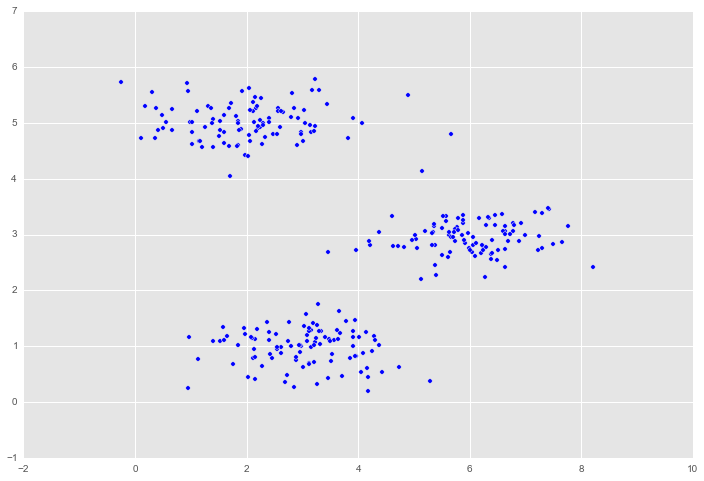

In [7]:
plt.scatter(data1[:,0], data1[:,1])

In [98]:
def kMeansInitCentroids(X,K):
    (m,n) = X.shape
    centroids = np.zeros((K,n))
    # randomly permute
    randidx = np.random.permutation(np.arange(X.shape[0]))
    # select first K
    centroids = X[randidx[0:K], :]  
    return centroids

In [99]:
def findClosestCentroids(X, centroids):
    K = centroids.shape[0]
    idx = np.zeros(X.shape[0])
    dist = np.zeros(K)
    for i in np.arange(X.shape[0]):
        for j in np.arange(K):
            dist[j] = np.sum (np.square(X[i,:]-centroids[j,:]))
        idx[i] = np.argmin(dist)
    return idx

In [100]:
def computeCentroids(X, idx, K):
    (m,n) = X.shape
    centroids = np.zeros((K,n))
    for k in np.arange(K):
        subset = idx==k
        centroids[k,:] = np.sum(X[subset,:])/ subset.size
    return centroids

In [101]:
def runKmeans(X, initial_centroids, max_iters):
    (m,n) = X.shape
    K = initial_centroids.shape[0]
    centroids = initial_centroids
    previous_centroids = centroids
    idx = np.zeros(m)
    for i in np.arange(max_iters):
        idx = findClosestCentroids(X, centroids)
        centroids = computeCentroids(X, idx, K)
    return centroids, idx

In [102]:
X = np.c_[data1[:,0],data1[:,1]]

In [126]:
initial_centroids = kMeansInitCentroids(X, 3)

In [127]:
centroids, idx = runKmeans(X, initial_centroids, max_iters = 100)

In [128]:
centroids

array([[ 4.53298243,  4.53298243],
       [ 0.01030749,  0.01030749],
       [ 2.12818646,  2.12818646]])

In [112]:
X.shape

(300L, 2L)

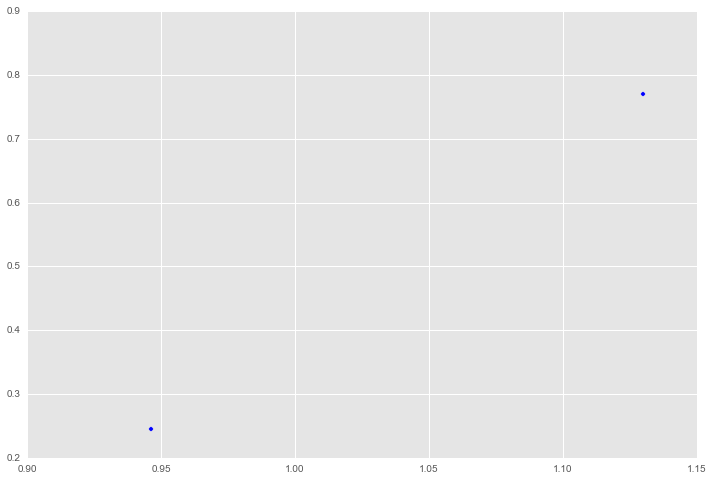

In [121]:
plt.scatter(X[:,0][idx==1],X[:,1][idx==1])

In [116]:
X[:,0][idx==0].shape

(138L,)